### MRI Brain Tumor Classification with Deep Convolutional Networks

MRI's play a crucial role in clinical diagnosis of brain tumors. Fast and accurate 
tumor detection can help doctors with early detection treatment planning. This can
greatly affect the survivability of the patient from this life-threatening disease.

In this project, I want to compare several convolutional deep learning models to classify MRI images of different tumor types and healthy non tumor images into there respective categories within a test and training set. These include:

   - Glioma
   - Meningioma
   - No-tumor
   - Pituitary

This task relevant to CNN modeling as it has several structural attributes that lends itself to this type of analysis:
    
   - small 2D images
   - intra-class variation
   - models learn rich image feature textures

Medical imaging tasks carry a much higher cost for misclassification than when selecting a dataset like CIFAR, so careful model evaluation and appropriate performance metrics are critical.  
    
Dataset Link: https://www.kaggle.com/datasets/mohamadabouali1/mri-brain-tumor-dataset-4-class-7023-images 

### Preparation: 

#### Evaluation Metrics
      
   The main comparison metric in this lab is **macro-averaged F1**:
   
   - The macro F1 average computes the F1 per class and the averages them,
     giving equal weight to all tumor classes regardless of how many samples 
     there are in the classes.

   This is an appropriate metric for tumor classification for the following reasons

   - Each tumor is important clinically, so missing a rare tumor type can be as serious as misclassifying a common type.
   
   - The metric will reward models that have good performance across all classes 
     and not just the most represented class.
   
   - This aligns with the business usage case since doctors and hospitals want a model
     that is highly accurate and reliable for all tumor types. Misclassification could result in delayed treatment or misdiagnosis especially if clinical controls are weak around the modeling and doctors have dependence on it.
   
#### Supporting Metrics: Per-class ROC–AUC and confusion matrices 
    
   In addition to macro-F1, I will also use:
   
   - **Per-class ROC curves and AUC**
   
        For all the tumor classes I can treat it as positive versus all other classes and use ROC-AUC. This measures how well the model can rank a tumor type against it not being this tumor type across thresholds. 
   
        In a real clinical setting, for example, we may choose a conservative threshold to give high recall. This could allow the model to be used to flag scans for  radiologist review.
   

   - **Confusion matrices**
   
        This is important for debugging and possibly understanding failures in the analysis by the model, such as a positive malignant tumor being classified as a benign one.    
   
#### Train/Test Splitting Method

For this project I will use a <b>Stratified 80/20 Split</b> implemented through kera tf using the validation parameter set to **validation_split=0.20** and fixed random seed.

This is the most appropriate for this dataset for the following reasons:

   ### Stratification Importance

   - MRI clinical datasets can have uneven class distributions such as many no tumor cases with less rare tumor types. Stratification will ensure that all classes maintain the same proportions in both the training and validation sets.
   
   - This also prevents bias toward dominate tumor categories. Since clinically, every tumor class matters and the split cant hide rare labels.
   

   ### Split Shuffling
   
   - Shuffling ensures the data will not correlate with directory, acquisition, or patient ordering/grouping. This would maintain a workflow where new scans arrive in an unpredictable order.
   
#### Why an 80/20 hold-out split mirrors real-world clinical setting  
    
Deep CNNs in medical imaging usually are trained once on a bulk of available data then evaluated on a held-out that can simulate real data. This is similar to the way CIFAR is split.

Using 80/20 mirrors medical practices because:

   - 80% gives enough data to learn high variance features
   - 20% gives a large and diverse validation set to measure generalization
   - It would avoid long retraining sessions that happen with full cross validation   

For medical applications this the most realistic since you can train once, validate on unseen patients then deploy. 

In [82]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

# model creation imports
from tensorflow.keras import layers, Sequential
from keras import Model
from keras.src.layers import InputLayer, SeparableConv2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Concatenate, Add, Reshape, Input

# utility imports
from tensorflow.keras.regularizers import l2

# augmentation imports
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.layers import RandomContrast, RandomBrightness

# other plotting and evaluation imports
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns
%matplotlib inline


print(tf.config.list_physical_devices('GPU'))
print('Keras:', keras.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras: 3.12.0


In [76]:
# Utility functions for summarizing outputs from models
def plot_history(history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='training')
    
    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.xlabel('epochs')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='training')
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')
    
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('epochs')
    plt.title('Loss')
    plt.legend()
    plt.show()


def summarize_models(nets, ds, class_names, fig_size = (15,5) ):
    plt.figure(figsize=fig_size)

    num_plots = len(nets)
    for i, net in enumerate(nets):
        # get output and labels for the model, as numpy
        y_true, y_pred = [], []
        for images, batch_labels in ds:
            preds = net.predict(images, verbose=0)
            preds = np.argmax(preds, axis=1)
            y_true.append(batch_labels.numpy())
            y_pred.append(preds)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        acc = mt.accuracy_score(y_true,y_pred)*100
        cm  = mt.confusion_matrix(y_true,y_pred, normalize='true')
        
        plt.subplot(1,num_plots,i+1)
        sns.heatmap(cm, 
                    xticklabels=class_names,
                    yticklabels=class_names,
                    cmap='Blues',
                    annot=False)
        plt.title(f'{net.name}:{acc:.2f}')
    
    plt.tight_layout()
    plt.show()
    
def eval_macro_f1(model, data):
    
    y_true = []
    y_pred = []
    
    for img, label in data:
        pred = model.predict(img, verbose=0)
        pred = np.argmax(pred, axis=1)
        y_true.append(label.numpy())
        y_pred.append(pred)
        
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    f1 = mt.f1_score(y_true, y_pred, average='macro')
    acc = mt.accuracy_score(y_true, y_pred)
    return print("Accuracy:",acc), print("F1-Macro",f1)

In [16]:
DATA_DIR = "data/BT-MRI Dataset/"
TRAIN_DIR = DATA_DIR + "Training"
TEST_DIR  = DATA_DIR + "Testing"


ds_train = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    image_size=(64, 64),
    color_mode='grayscale',
    validation_split=0.2,
    shuffle=True,
    subset='training',
    seed=42)

ds_val = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    image_size=(64, 64),
    color_mode='grayscale',
    validation_split=0.2,
    subset='validation',
    seed=42)

class_names = ds_train.class_names

dict_class_names_to_int = {}
for i, cls in enumerate(class_names):
    dict_class_names_to_int[cls] = i


ds_test = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='int',
    image_size=(64, 64),
    color_mode='grayscale',
    seed=42)

    
def normalize(image, label):
    image = image / 255.0
    return image, label

# Data Expansion
augment = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1)
], name='augment')

ds_train = (ds_train.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
                    .map(lambda x, y: (augment(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
                    .prefetch(tf.data.AUTOTUNE))

ds_test = (ds_test.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
                  .prefetch(tf.data.AUTOTUNE))


ds_val = (ds_val.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
                  .prefetch(tf.data.AUTOTUNE))


NUM_CLASSES = len(class_names)
print(NUM_CLASSES)
print(class_names)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
4
['Glioma', 'Meningioma', 'No-tumor', 'Pituitary']


### Data Expansion Choice

MRIs can vary slightly from patient to patient resulting from differences in the scanner, head position, tilt. Small augmentations can help the model learn specific structures of different tumor types. These should not distort the images too much.

Specifically Used:
    
   - Random Horizontal Flip
   - Random Rotation
   - Random Zoom   

Training


2025-11-28 16:10:21.852429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node augment_1/random_zoom_1_1/Add/_14}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-11-28 16:10:21.852446: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16421530126264371487
2025-11-28 16:10:21.852449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node augment_1/random_zoom_1_1/Add/_14}}]]
	 [[GroupCrossDeviceControlEdges_0/NoOp/_21]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-11-28 16:10:21.852452: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 609032762644857737


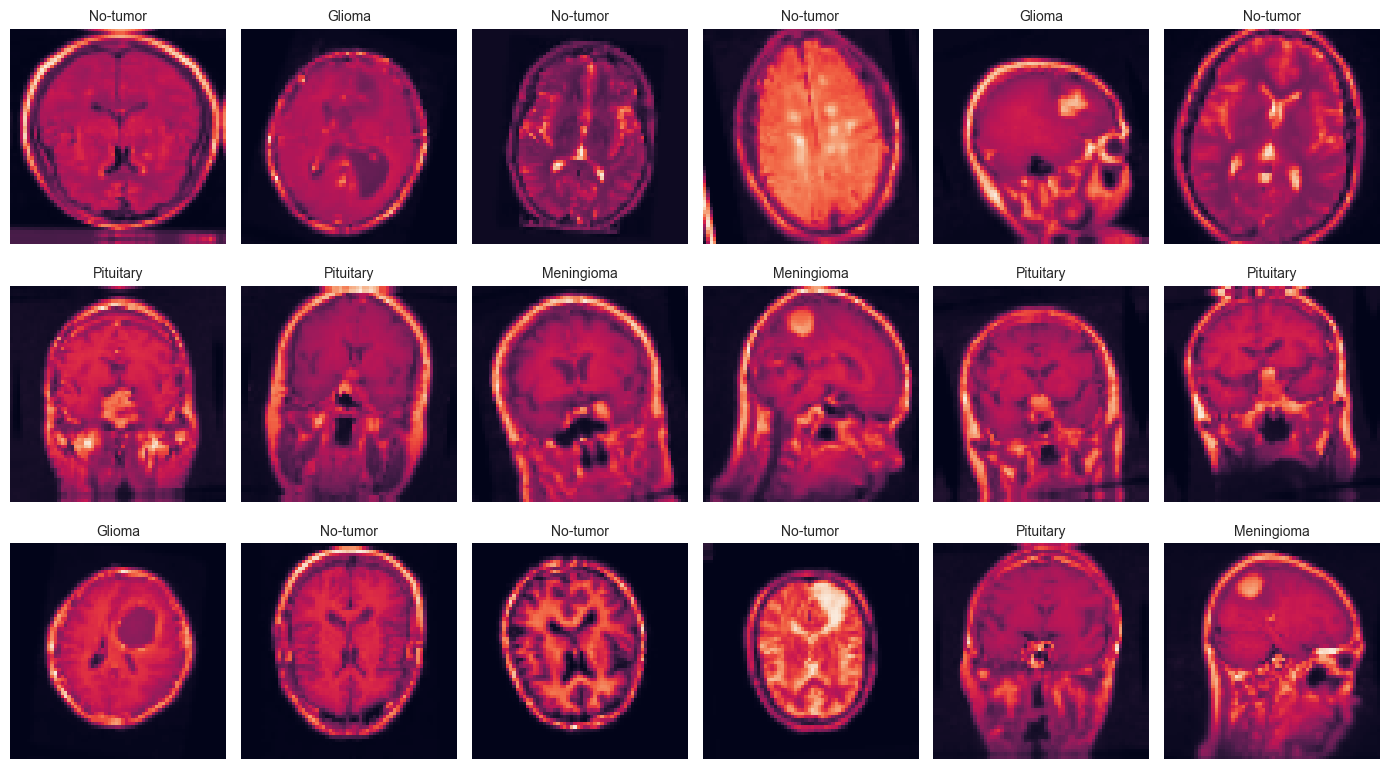

Testing


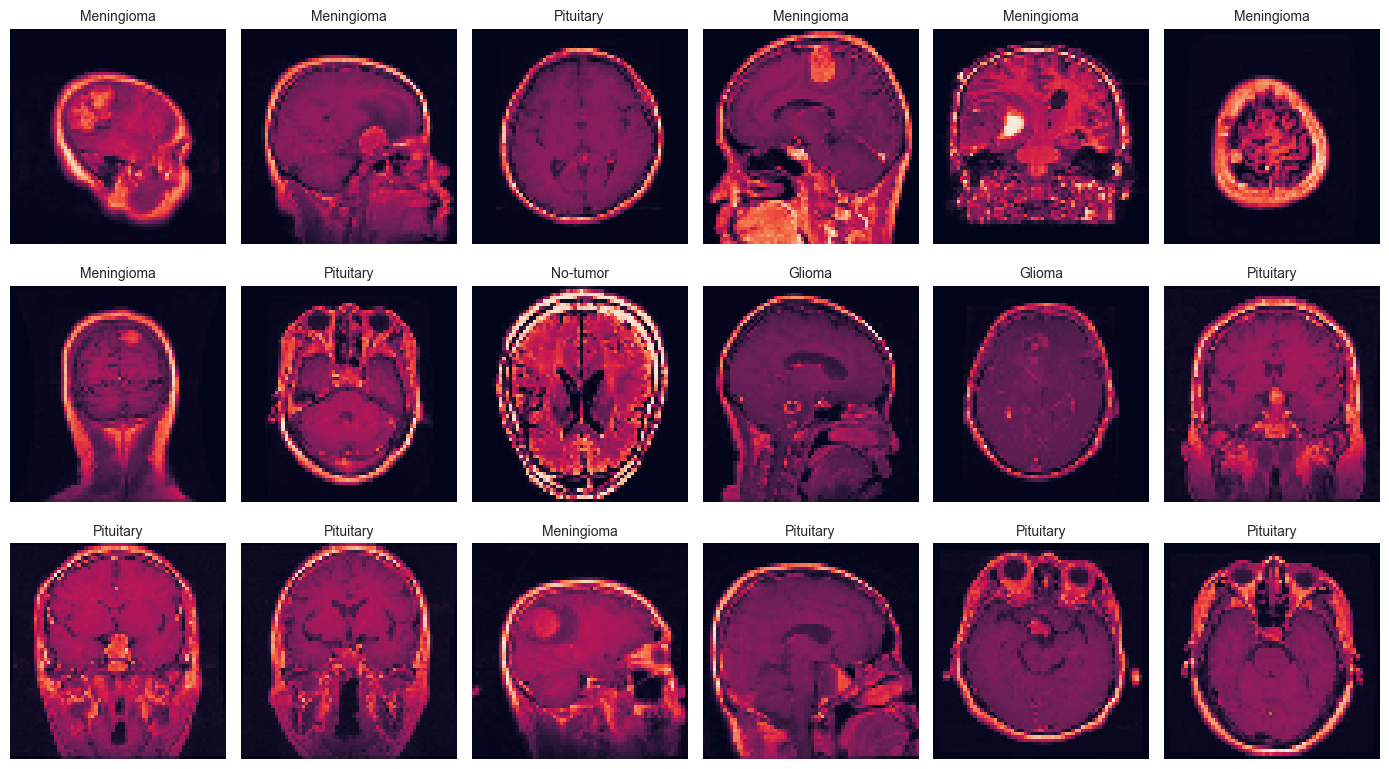

In [17]:
# Used chat to help with this. It just adjusted your plot_gallery helper 
# function to my dataset. I hope this is ok?

def plot_gallery(ds, class_names, n_row=3, n_col=6, figsize=(14, 8)):
    for images, labels in ds.take(1):
        images = images.numpy()
        labels = labels.numpy()
        break

    plt.figure(figsize=figsize)
    total_images = images.shape[0]
    total = min(n_row * n_col, total_images)

    for i in range(total):
        plt.subplot(n_row, n_col, i+1)

        img = images[i]
        if img.shape[-1] == 1:
            img = img.squeeze(-1)

        plt.imshow(img)
        plt.title(class_names[labels[i]], fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

print("Training")
plot_gallery(ds_train, class_names)

print("Testing")
plot_gallery(ds_test, class_names)

## Modeling Section

## MLP Baseline Model

In [18]:
%%time
# Baseline MLP
def baselineMLP(num_classes):
    model = Sequential(name='BaselineMLP')
    model.add(InputLayer(shape=(64, 64, 1)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(1e-4), 
                  metrics=['accuracy'])
    return model

mlp = baselineMLP(NUM_CLASSES)
mlp.summary()

history_mlp = mlp.fit(ds_train, epochs=20, validation_data=ds_val, verbose=1)

    

Model: "BaselineMLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,163,844 (8.25 MB)

 Trainable params: 2,163,844 (8.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4805 - loss: 1.1514 - val_accuracy: 0.6173 - val_loss: 0.9775
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5864 - loss: 1.0114 - val_accuracy: 0.5919 - val_loss: 0.9602
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6118 - loss: 0.9588 - val_accuracy: 0.6611 - val_loss: 0.8957
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6142 - loss: 0.9542 - val_accuracy: 0.6646 - val_loss: 0.8594
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6289 - loss: 0.9283 - val_accuracy: 0.6725 - val_loss: 0.8517
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6243 - loss: 0.9273 - val_accuracy: 0.6883 - val_loss: 0.8210
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6383 - loss: 0.9226 - val_accuracy: 0.6953 - val_loss: 0.8264
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6411 - loss: 0.9119 - val_accu

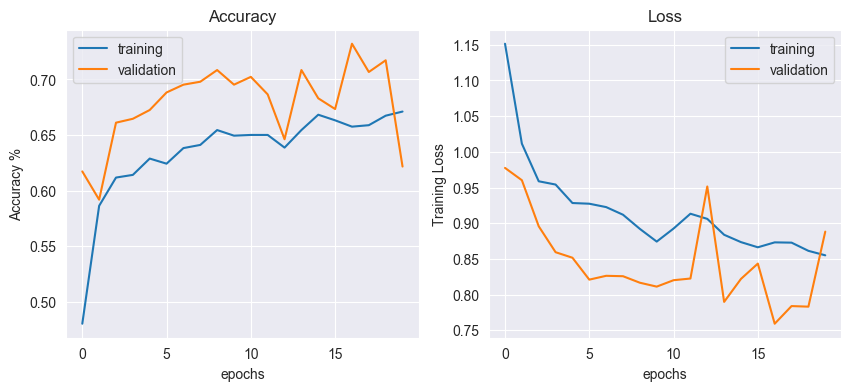

Accuracy: 0.6468344774980931
F1-Macro 0.6246375630187783


2025-11-29 17:37:30.891255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [77]:
plot_history(history_mlp)
mlp_f1 = eval_macro_f1(mlp, ds_test) 

This model served as an MLP baseline. It performed reasonably well on the dataset, with accuracy reaching about 65% accuracy and 62% for F1-score. Although, the training and validation curves show that the model may have trouble learning the more complex structures in the images.

After about 10 to 12 epochs the validation curves become very noisy, suggesting the model has reached representative capacity. The MLP provides a good point of comparison but the lack of convolutional layers limited its ability to capture texture and shape features in the MRI's.

## Model 2: Resnet

In [20]:
%time
# ResNet
concat_filter_size = 64

def create_res_block(name, filters):
    return Sequential([Conv2D(32, (1, 1),
                       padding='same',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(1e-5)),
                       BatchNormalization(),
                       Activation('relu'),
                       
                       Conv2D(32, (3, 3),
                       padding='same',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(1e-5)),
                       BatchNormalization(),
                       Activation('relu'),
                       
                       Conv2D(filters,(1, 1),
                              padding='same',
                              kernel_initializer='he_uniform',
                              kernel_regularizer=l2(1e-5)),
                              BatchNormalization()
                       ],name=name)

res_3x3a = create_res_block('res_3x3a', concat_filter_size)
res_3x3b = create_res_block('res_3x3b', concat_filter_size)

def build_resnet(num_classes):
    
    input_holder = Input(shape=(64, 64, 1))
    
    x = Conv2D(32, (3,3), strides=1, 
               padding='same',
               kernel_initializer='he_uniform')(input_holder)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(32, (3,3), strides=1, 
               padding='same',
               kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Block A
    x_split = Conv2D(concat_filter_size, (1,1),padding='same')(x)
    x_res = res_3x3a(x_split)
    x = Add()([x_res, x_split])
    x = Activation('relu')(x)
    
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Block B
    x_split = Conv2D(concat_filter_size, (1,1),padding='same')(x)
    x_res = res_3x3b(x_split)
    x = Add()([x_res, x_split])
    x = Activation('relu')(x)
    
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Head
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_holder, outputs=outputs, name='ResNet')
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(1e-4),
        metrics=['accuracy']
    )
    
    return model


resnet = build_resnet(NUM_CLASSES)
resnet.summary()

history_resnet = resnet.fit(ds_train, epochs=20, validation_data=ds_val, verbose=1)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 μs
Wall time: 1.67 μs


Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │        320 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │      9,248 │ activation_12[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ activation_13[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │      2,112 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_3x3a            │ (None, 32, 32,    │     13,952 │ conv2d_17[0][0]   │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 32, 32,    │          0 │ res_3x3a[0][0],   │
│                     │ 64)               │            │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 32, 32,    │          0 │ add_4[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ activation_14[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16,    │      4,160 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_3x3b            │ (None, 16, 16,    │     13,952 │ conv2d_18[0][0]   │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 16, 16,    │          0 │ res_3x3b[0][0],   │
│                     │ 64)               │            │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 16, 16,    │          0 │ add_5[0][0]     

 Total params: 1,126,244 (4.30 MB)

 Trainable params: 1,125,604 (4.29 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.4646 - loss: 4.1337 - val_accuracy: 0.3774 - val_loss: 2.4422
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5370 - loss: 4.0065 - val_accuracy: 0.5587 - val_loss: 2.0639
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.5683 - loss: 4.2698 - val_accuracy: 0.6655 - val_loss: 1.9501
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.5779 - loss: 4.7873 - val_accuracy: 0.7417 - val_loss: 1.6867
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6088 - loss: 4.5934 - val_accuracy: 0.6944 - val_loss: 3.0506
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.6363 - loss: 3.8103 - val_accuracy: 0.6856 - val_loss: 2.8518
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6611 - loss: 3.5744 - val_accuracy: 0.6708 - val_loss: 3.7048
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.6661 - loss: 3.3597 - val_acc

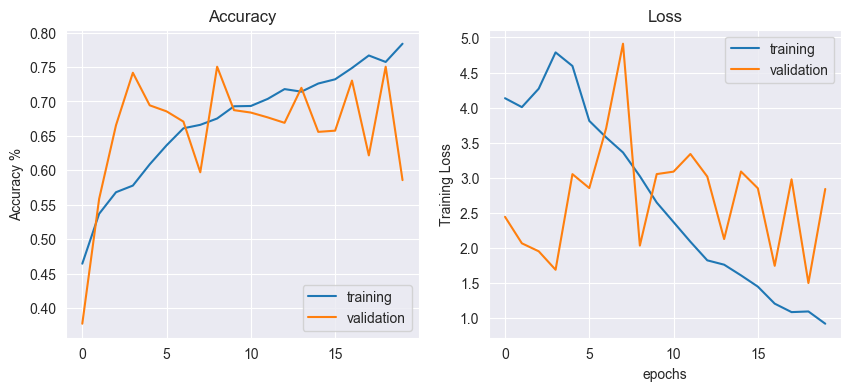

Accuracy: 0.5415713196033562
F1-Macro 0.5085445225007033


2025-11-28 16:16:21.245192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
plot_history(history_resnet)
resnet_f1 = eval_macro_f1(resnet, ds_test)

This model added residual skip connections which helps the gradients flow to deeper layers, diminishing vanishing gradient problems. This model provided accuracy at 54% and F1 50%, the training accuracy curves increased to around the 75% range but the validation again fluctuated across epochs. Validation loss also fluctuated wildly suggesting the model may learn some useful features but is unstable and may be overfitting.

The Resnet model may be learning spatial structures in the data, but isn't as consistently viable for the MRI images. A deeper model and more regularized model may be needed.

## Model 3 Deeper ResNet Variant

In [22]:
"""
ResNet variant with the following changes:
 - larger concat_filter_size from 64 -> 96. Give more feature capacity 
 - Deeper filters in the residual blocks(Block1: 32 -> 48 & Block2: 32 -> 96). 
"""

concat_filter_size_2 = 96

def create_res_block_variant(name, filters):
    return Sequential([Conv2D(48, (1, 1),
                       padding='same',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(1e-5)),
                       BatchNormalization(),
                       Activation('relu'),
                       
                       Conv2D(48, (3, 3),
                       padding='same',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(1e-5)),
                       BatchNormalization(),
                       Activation('relu'),
                       
                       Conv2D(filters, (1, 1),
                              padding='same',
                              kernel_initializer='he_uniform',
                              kernel_regularizer=l2(1e-5)),
                              BatchNormalization()
                       ],name=name)

res_3x3a_var = create_res_block_variant('res_3x3a', concat_filter_size_2)
res_3x3b_var = create_res_block_variant('res_3x3b', concat_filter_size_2)


def build_resnet_variant(num_classes):
    
    input_holder = Input(shape=(64, 64, 1))
    
    x = Conv2D(32, (3,3), strides=1, 
               padding='same',
               kernel_initializer='he_uniform')(input_holder)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(32, (3,3), strides=1, 
               padding='same',
               kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Block A
    x_split = Conv2D(concat_filter_size_2, (1,1),padding='same')(x)
    x_res = res_3x3a_var(x_split)
    x = Add()([x_res, x_split])
    x = Activation('relu')(x)
    
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Block B
    x_split = Conv2D(concat_filter_size_2, (1,1),padding='same')(x)
    x_res = res_3x3b_var(x_split)
    x = Add()([x_res, x_split])
    x = Activation('relu')(x)
    
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Dense Layer
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_holder, outputs=outputs, name='ResNet_Variant')
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(1e-4),
        metrics=['accuracy']
    )
    
    return model


resnet_variant = build_resnet_variant(NUM_CLASSES)
resnet_variant.summary()

history_resnet_variant = resnet_variant.fit(ds_train, epochs=20, validation_data=ds_val, verbose=1)

Model: "ResNet_Variant"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │        320 │ input_layer_14[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │      9,248 │ activation_20[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │      3,168 │ max_pooling2d_7[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_3x3a            │ (None, 32, 32,    │     30,912 │ conv2d_27[0][0]   │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 32, 32,    │          0 │ res_3x3a[0][0],   │
│                     │ 96)               │            │ conv2d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 32, 32,    │          0 │ add_6[0][0]       │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 16, 16,    │          0 │ activation_22[0]… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │      9,312 │ max_pooling2d_8[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_3x3b            │ (None, 16, 16,    │     30,912 │ conv2d_28[0][0]   │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 16, 16,    │          0 │ res_3x3b[0][0],   │
│                     │ 96)               │            │ conv2d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 16, 16,    │          0 │ add_7[0][0]     

 Total params: 1,690,660 (6.45 MB)

 Trainable params: 1,689,764 (6.45 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.4792 - loss: 3.9314 - val_accuracy: 0.4361 - val_loss: 1.6800
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.5523 - loss: 3.9312 - val_accuracy: 0.6436 - val_loss: 1.6084
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.5814 - loss: 4.2975 - val_accuracy: 0.7785 - val_loss: 1.2471
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.6206 - loss: 4.1951 - val_accuracy: 0.7653 - val_loss: 2.0735
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.6394 - loss: 3.8472 - val_accuracy: 0.6970 - val_loss: 3.2005
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.6554 - loss: 3.4456 - val_accuracy: 0.6996 - val_loss: 2.4840
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.6643 - loss: 3.3115 - val_accuracy: 0.7671 - val_loss: 2.2550
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.6939 - loss: 2.7703 - 

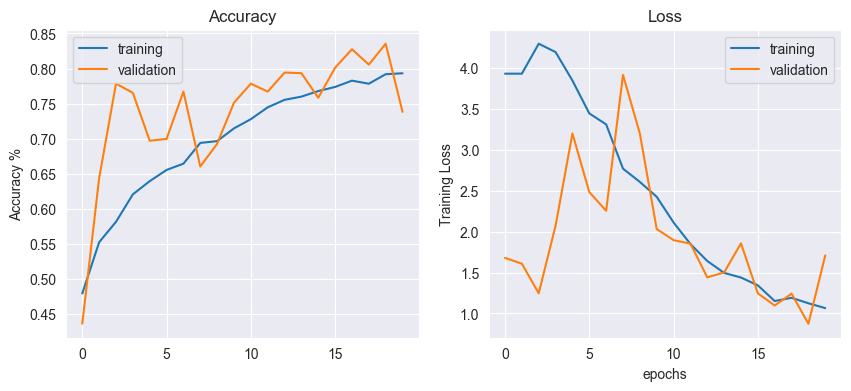

Accuracy: 0.6819221967963387
F1-Macro 0.6546626683470969


2025-11-28 16:20:31.035736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
plot_history(history_resnet_variant)
resnet_var_f1 = eval_macro_f1(resnet_variant, ds_test)

This version increased the model capacity by expanding the number of filters from 64 to 96 and widening the residual blocks from 32 to 48. The goal of this was to allow the network to richer features from the images.

Training and validation improved with accuracy peaking around 80%. The loss curves appeared to decrease smoother compared to the original ResNet implementation suggested the variant learned slightly more stable features. The validation loss is still fluctuating so, maybe it has some sensitivity to noise in the image data. Overall, ResNet variant achieved 68% accuracy and 65% F1 indicating some good performance across all the tumor classes.

## Model 4 Xception

In [24]:
concat_filt_size = 64

def xception_block(filters):
    return Sequential([
        SeparableConv2D(filters=filters,
                        kernel_size=(3, 3),
                        padding='same',
                        depth_multiplier=1,
                        activation='relu'),
        
        
        
        SeparableConv2D(filters=filters,
                        kernel_size=(3, 3),
                        padding='same',
                        depth_multiplier=1,
                        activation='relu')
    ])
        

def build_xception(num_classes):
    input_holder = Input(shape=(64, 64, 1))
    
    x = layers.Conv2D(filters=32, 
                      kernel_size=(3,3),
                      strides=(1,1),
                      padding='same',
                      kernel_regularizer=l2(1e-6),
                      kernel_initializer='he_uniform')(input_holder)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters=64, 
                      kernel_size=(3,3),
                      strides=(1,1),
                      padding='same',
                      kernel_regularizer=l2(1e-6),
                      kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    
    # Block A
    x_split = Conv2D(64, kernel_size=(1,1), padding='same',
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(1e-5))(x)
    
    x_res = xception_block(64)(x_split)
    
    x = layers.Add()([x_res, x_split])
    x = layers.Activation('relu')(x)
    
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Block B
    x_split = Conv2D(128, kernel_size=(1,1), padding='same',
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(1e-5))(x)
    
    x_res = xception_block(128)(x_split)
    x = layers.Add()([x_res, x_split])
    x = layers.Activation('relu')(x)
    
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Dense Layer
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_holder, outputs=outputs, name='Xception')
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    
    return model

xception = build_xception(NUM_CLASSES)
xception.summary()
    
history_xception = xception.fit(ds_train, epochs=20, validation_data=ds_val, verbose=1)

Model: "Xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 64, 64,    │        320 │ input_layer_17[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 64, 64,    │     18,496 │ activation_24[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 64,    │      4,160 │ activation_25[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 64, 64,    │      9,472 │ conv2d_31[0][0]   │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 64, 64,    │          0 │ sequential_4[0][… │
│                     │ 64)               │            │ conv2d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 64, 64,    │          0 │ add_8[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ activation_26[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 32,    │      8,320 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 32, 32,    │     35,328 │ conv2d_32[0][0]   │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 32, 32,    │          0 │ sequential_5[0][… │
│                     │ 128)              │            │ conv2d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 32, 32,    │          0 │ add_9[0][0]       │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ activation_27[0]

 Total params: 8,498,756 (32.42 MB)

 Trainable params: 8,498,564 (32.42 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.4232 - loss: 13.0065 - val_accuracy: 0.6769 - val_loss: 1.8622
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.5407 - loss: 11.7875 - val_accuracy: 0.7548 - val_loss: 2.2328
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.5665 - loss: 12.1039 - val_accuracy: 0.7916 - val_loss: 3.6291
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.5908 - loss: 14.3520 - val_accuracy: 0.8144 - val_loss: 5.5267
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.6199 - loss: 15.6404 - val_accuracy: 0.7285 - val_loss: 7.8438
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.6460 - loss: 12.7802 - val_accuracy: 0.7294 - val_loss: 8.8359
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.6486 - loss: 12.5184 - val_accuracy: 0.8012 - val_loss: 6.4773
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.6501 - loss: 13.6111

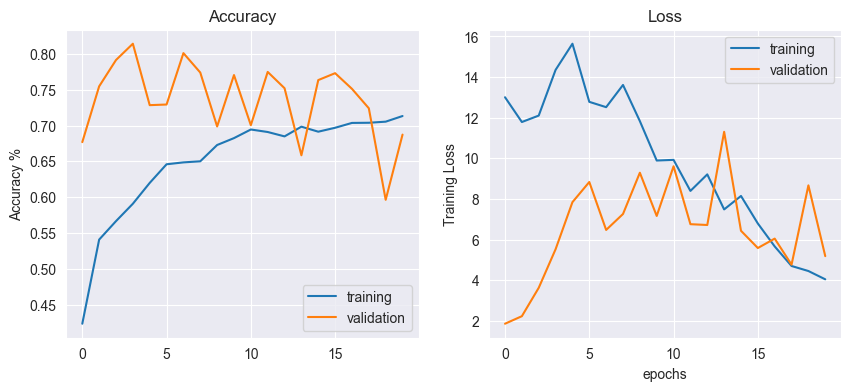

Accuracy: 0.6498855835240275
F1-Macro 0.6239223537523055


2025-11-28 16:24:08.188718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
plot_history(history_xception)
xception_f1 = eval_macro_f1(xception, ds_test)

This model used a modified Xception style architecture using depthwise separable convolution layers and achieved an accuracy of 65% and F1 of 62%. Performance was a little better than the MLP baseline slightly below the ResNet architectures. The metric curves suggest that the model does learn quickly but does become unstable in later epochs probably because the dense layer is too large for the MRI images. 

The Xception model does capture useful image features but is less stable and may generalize less than the ResNet models.

## Model 4 Xception Variant

In [29]:
def xception_block_variant(filters):
    return Sequential([
        SeparableConv2D(filters=filters,
                        kernel_size=(3, 3),
                        padding='same',
                        depth_multiplier=1,
                        activation='relu'),
        
        
        
        SeparableConv2D(filters=filters,
                        kernel_size=(3, 3),
                        padding='same',
                        depth_multiplier=1,
                        activation='relu')
    ])
        

def build_xception_variant(num_classes):
    input_holder = Input(shape=(64, 64, 1))
    
    
    x = layers.Conv2D(filters=32, 
                      kernel_size=(3,3),
                      strides=(1,1),
                      padding='same',
                      kernel_regularizer=l2(1e-6),
                      kernel_initializer='he_uniform')(input_holder)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters=64, 
                      kernel_size=(3,3),
                      strides=(1,1),
                      padding='same',
                      kernel_regularizer=l2(1e-6),
                      kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    
    # Block A
    x_split = Conv2D(96, kernel_size=(1,1), padding='same',
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(1e-5))(x)
    
    x_res = xception_block(96)(x_split)
    
    x = layers.Add()([x_res, x_split])
    x = layers.Activation('relu')(x)
    
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Block B
    x_split = Conv2D(192, kernel_size=(1,1), padding='same',
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(1e-5))(x)
    
    x_res = xception_block(192)(x_split)
    x = layers.Add()([x_res, x_split])
    x = layers.Activation('relu')(x)
    
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # Dense Layer
    x = Flatten()(x)
    x = Dense(384, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(192, activation='relu', kernel_regularizer=l2(1e-4))(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_holder, outputs=outputs, name='Xception_Variant')
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
xception_variant = build_xception_variant(NUM_CLASSES)
xception_variant.summary()
    
history_xception_variant = xception_variant.fit(ds_train, epochs=40, 
                                                validation_data=ds_val, 
                                                callbacks=[early_stopping], 
                                                verbose=1)


Model: "Xception_Variant"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64,    │        320 │ input_layer_23[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │     18,496 │ activation_32[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 64, 64,    │      6,240 │ activation_33[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 64, 64,    │     20,352 │ conv2d_39[0][0]   │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 64, 64,    │          0 │ sequential_8[0][… │
│                     │ 96)               │            │ conv2d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 64, 64,    │          0 │ add_12[0][0]      │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ activation_34[0]… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │     18,624 │ max_pooling2d_14… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 32, 32,    │     77,568 │ conv2d_40[0][0]   │
│ (Sequential)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 32, 32,    │          0 │ sequential_9[0][… │
│                     │ 192)              │            │ conv2d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 32, 32,    │          0 │ add_13[0][0]      │
│ (Activation)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 16, 16,    │          0 │ activation_35[0]

 Total params: 19,091,428 (72.83 MB)

 Trainable params: 19,091,236 (72.83 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - accuracy: 0.4770 - loss: 12.8225 - val_accuracy: 0.6786 - val_loss: 2.1487
Epoch 2/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.5551 - loss: 13.5906 - val_accuracy: 0.7356 - val_loss: 3.5402
Epoch 3/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.6000 - loss: 12.9858 - val_accuracy: 0.7837 - val_loss: 3.8119
Epoch 4/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.6204 - loss: 12.9271 - val_accuracy: 0.8065 - val_loss: 4.8433
Epoch 5/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.6368 - loss: 14.7839 - val_accuracy: 0.7671 - val_loss: 7.8056
Epoch 6/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.6346 - loss: 16.1874 - val_accuracy: 0.8056 - val_loss: 8.3414


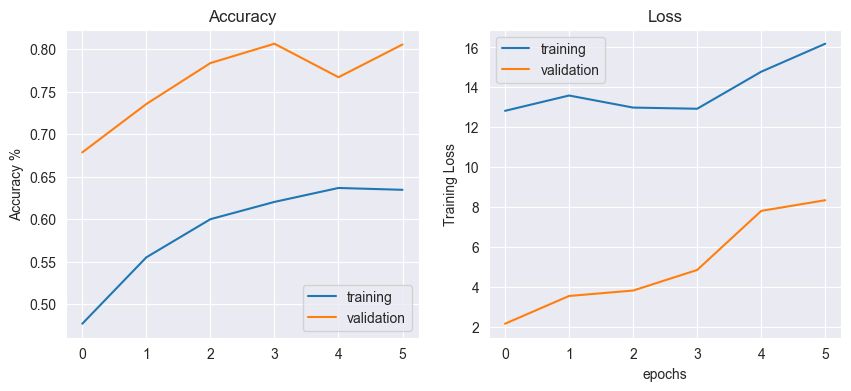

Accuracy: 0.6536994660564455
F1-Macro 0.5708522737443946


2025-11-28 16:46:37.627191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
plot_history(history_xception_variant)
xception_f1_variant = eval_macro_f1(xception_variant, ds_test)

The Xception variant is much larger and deeper than the previous models. It used extremely large separable convolution layers with channels expanded from 96 to 192 and very large dense layer going from 384 to 192. I thought this network was way too large for grayscale images but thought id try a over-sized network experimentally for the last model. 

The model used early stopping which activated at epoch 6. Obviously the model is overly parametrized for the dataset so training loss started high and remained high, validation loss fluctuated again while accuracy grew slowly for several epochs. 

### Model Comparison Results

2025-11-28 16:50:31.729371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-28 16:50:33.158124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-28 16:50:34.567886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-28 16:50:36.228297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


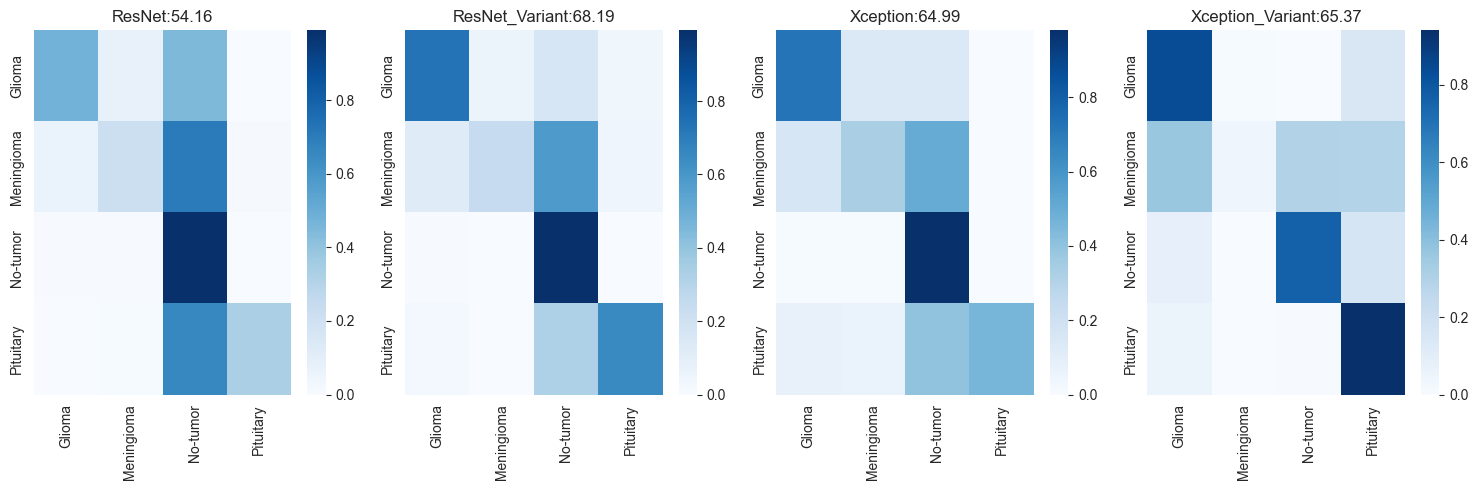

In [31]:
summarize_models(
    nets= [resnet, resnet_variant, xception, xception_variant],
    ds=ds_test,
    class_names=class_names)

No-tumor was easiest class with all models showing very strong diagonal for that class. This makes sense because the absence of tumor structure produces very distinct patterns.

The ResNet variant clearly performs the best overall showing the strongest diagonal for 3 of 4 classes, especially for Glioma, No tumor, and Pituitary.

Xception and Xception variant performed but show more confusion between Glioma and Meningioma / Meningioma and Pituitary.
This indicates that these architectures captured tumor structure but not finer difference boundaries between tumor types.

The original ResNet performed the worst with a weaker diagonal more consistent with its lower accuracy 54%.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━

2025-11-29 20:48:41.838115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


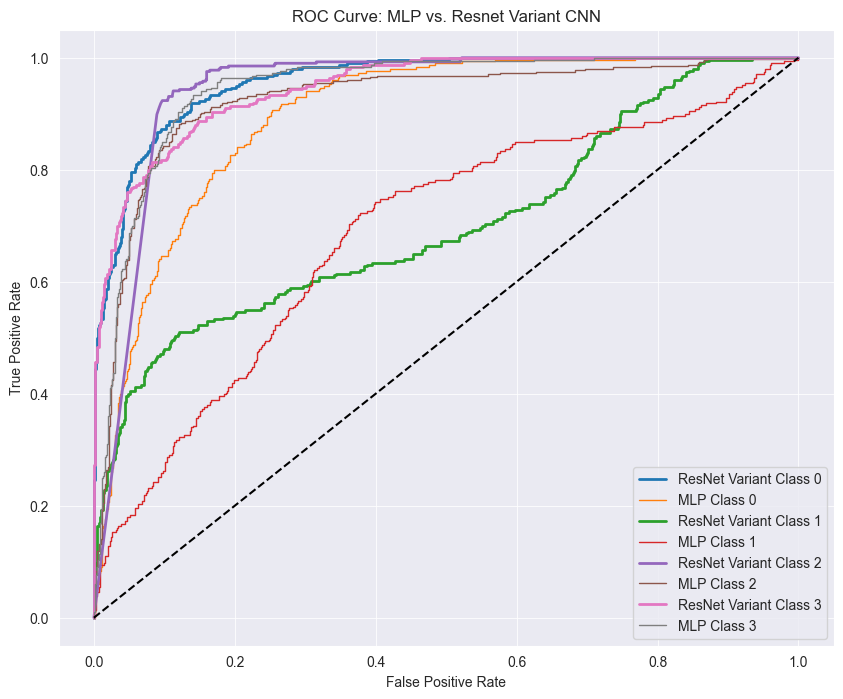

In [78]:
# ROC/AUC Metrics

y_true = []
cnn_probs = []
mlp_probs = []

for images, labels in ds_test:
    y_true.append(labels.numpy())
    cnn_probs.append(resnet_variant.predict(images))
    mlp_probs.append(mlp.predict(images))
    
y_true = np.concatenate(y_true)
cnn_probs = np.concatenate(cnn_probs)
mlp_probs = np.concatenate(mlp_probs)

y_true_f = label_binarize(y_true, classes=range(NUM_CLASSES))

cnn_auc = roc_auc_score(y_true_f, cnn_probs, average='macro')
mlp_auc = roc_auc_score(y_true_f, mlp_probs, average='macro')

print('CNN AUC: {:.4f}'.format(cnn_auc))
print('MLP AUC: {:.4f}'.format(mlp_auc))


# ROC Curve
plt.figure(figsize=(10, 8))

for class_id in range(NUM_CLASSES):
    false_pos_rate_cnn, true_pos_rate_cnn, _ = roc_curve(y_true_f[:, class_id], cnn_probs[:, class_id])
    false_pos_rate_mlp, true_pos_rate_mlp, _ = roc_curve(y_true_f[:,class_id], mlp_probs[:, class_id])
    
    plt.plot(false_pos_rate_cnn, 
             true_pos_rate_cnn, 
             label=f'ResNet Variant Class {class_id}',
             linewidth=2)
    plt.plot(false_pos_rate_mlp, true_pos_rate_mlp,
             label=f'MLP Class {class_id}',
             linewidth=1)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: MLP vs. Resnet Variant CNN')
plt.legend(loc='lower right')
plt.grid(alpha=0.8)
plt.show()
    

To compare the CNN with the baseline MLP I used a per class ROC curve and the AUC. The ResNet variant curve produced a steeper ROC for all the classes, especially for tumor type Class 0: Glioma and Class 2: No Tumor where the true positive rate rises quickly with no significant increase in false positives. The AUC solidifies this with ResNet variant AUC at 88% and MLP AUC at 86%. 

Both models performed well but ResNet variant curves closer the upper left showing better separation of classes. The largest gap is between Class 1: Meningioma and Class 2: No Tumor where MLP has flatter curves. Overall ResNet variant had higher discriminative power for more visually complex tumor patterns, and outperformed MLP across almost all other classes. 

In [72]:
from keras.src.optimizers import Adam
from keras.src.applications.densenet import DenseNet121
from keras.src.layers import Lambda
from keras.applications.densenet import preprocess_input
# MobileNetV2 from 
# https://keras.io/api/applications/densenet/#densenet121-function

def transfer_densenet121(num_classes):
    inputs = layers.Input(shape=(64, 64, 1))
    
    # Needed to convert to grayscale use Lambda function to work with tf
    x = Lambda(lambda t: tf.image.grayscale_to_rgb(t))(inputs)
    
    # Resizing to appropriate sizing for imagenet
    x = layers.Resizing(224, 224)(x)
    x = layers.Lambda(preprocess_input)(x)
    
    base = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base.trainable = False
    
    x = base(x, training=False)
    out = layers.Dense(num_classes, activation='softmax')(x)

    # Build model
    model = Model(inputs=inputs, outputs=out, name="DenseNet121")
    
    model.compile(
        optimizer=Adam(1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    
    return model


densenet121_transfer_model = transfer_densenet121(NUM_CLASSES)
densenet121_transfer_model.summary()

history_densenet121_transfer_model = densenet121_transfer_model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_val,
    verbose=1)

Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_74 (InputLayer)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_53 (Lambda)              │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_11 (Resizing)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_54 (Lambda)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 373ms/step - accuracy: 0.2530 - loss: 1.4162 - val_accuracy: 0.2636 - val_loss: 1.4203
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.2525 - loss: 1.4064 - val_accuracy: 0.2644 - val_loss: 1.4125
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 205ms/step - accuracy: 0.2147 - loss: 1.4011 - val_accuracy: 0.2443 - val_loss: 1.4083
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - accuracy: 0.1639 - loss: 1.3977 - val_accuracy: 0.2075 - val_loss: 1.4059
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 203ms/step - accuracy: 0.1503 - loss: 1.3963 - val_accuracy: 0.1874 - val_loss: 1.4042
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.1565 - loss: 1.3957 - val_accuracy: 0.1681 - val_loss: 1.4025
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 0.1606 - loss: 1.3942 - val_accuracy: 0.1559 - val_loss: 1.4009
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.1737 - loss: 1

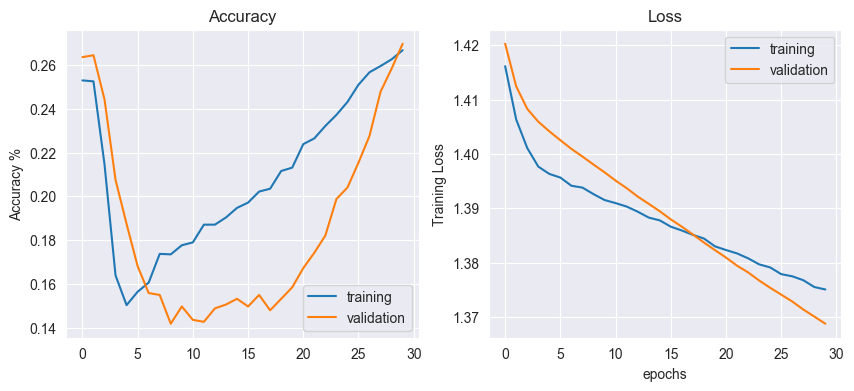

Accuracy: 0.28604118993135014
F1-Macro 0.111474435196195


2025-11-29 00:26:54.338445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [73]:
plot_history(history_densenet121_transfer_model)
densenet_f1 = eval_macro_f1(densenet121_transfer_model, ds_test)

DenseNet-121 performed very poorly on this dataset with an accuracy of 28% and F1 of only 11%. Both training and validation curves showed no improvement across epochs and loss didn't decrease all that much. This indicated that the model didn't transfer any meaningful features from imagenet to the MRI images.

I think the main reason is that DenseNet is trained on 224 x 224 rgb images which are very different from the grayscale MRI images. Even after converting from grayscale to rgb and resizing input, the filters in DenseNet are still tuned for natural colorful scenes and not flat featured medical images. The model couldn't adapt to this unfamiliar domain so, for my chosen dataset imagenet was a complete mismatch. 

2025-11-29 22:15:43.790901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


ResNet-Variant AUC: 0.8878
DenseNet AUC: 0.6016


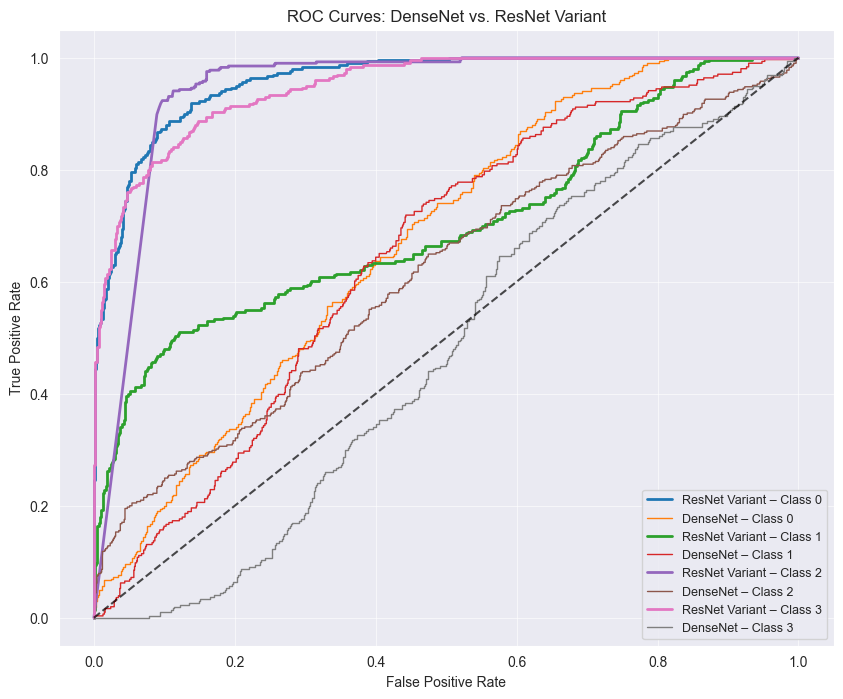

In [81]:
y_true = []
cnn_probs = []
dense_probs = []


for images, labels in ds_test:
    y_true.append(labels.numpy())
    cnn_probs.append(resnet_variant.predict(images, verbose=0))
    dense_probs.append(densenet121_transfer_model.predict(images, verbose=0))


y_true = np.concatenate(y_true)
cnn_probs = np.concatenate(cnn_probs)
dense_probs = np.concatenate(dense_probs)


y_true_f = label_binarize(y_true, classes=range(NUM_CLASSES))


cnn_auc = roc_auc_score(y_true_f, cnn_probs, average='macro')
dense_auc = roc_auc_score(y_true_f, dense_probs, average='macro')

print("ResNet-Variant AUC: {:.4f}".format(cnn_auc))
print("DenseNet AUC: {:.4f}".format(dense_auc))


plt.figure(figsize=(10, 8))

for class_id in range(NUM_CLASSES):
    false_pos_cnn, true_pos_cnn, _ = roc_curve(y_true_f[:, class_id], cnn_probs[:, class_id])
    false_pos_dense, true_pos_dense, _ = roc_curve(y_true_f[:, class_id], dense_probs[:, class_id])

    plt.plot(false_pos_cnn, true_pos_cnn, linewidth=2,
             label=f"ResNet Variant – Class {class_id}")
    plt.plot(false_pos_dense, true_pos_dense, linewidth=1,
             label=f"DenseNet – Class {class_id}")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: DenseNet vs. ResNet Variant")
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.6)
plt.show()

The ResNet variant was far more suitable for grayscale classification than large the imagenet transfer models. 

The AUC gap 0.8878 vs 0.6016 confirmed that domain mismatched transfer learning was not a good choice compared to a smaller, task oriented CNN. Actually, this seemed to be a continuing theme for this dataset in which more compact models worked best. 